In [1]:
########################Import Modules##########################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import corner
import copy as Makecopy
import time
from matplotlib import colors
import scipy as sp

from ipywidgets import IntProgress
from IPython.display import display

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

#####################################

# Generate Image with One Source

In [60]:
def Template_Equation(x,y,theta):
    X,Y,A = theta
    R = 3
    template = A*np.exp(-(((x-X)**2 + (y-Y)**2)/(2*R**2)))
    return template

In [82]:
npix = 50
x = np.arange(0, npix, 1, float)
y = x[:,np.newaxis]


#Locations ,Spatial extent and Flux
X = 25
Y = 25
A = 15

theta_pic = np.array([X,Y,A])

#Gaussian Noise
noise_sigma = 1.0
Noise = np.random.normal(0,noise_sigma,(npix,npix))

# Image data
Img_data = Template_Equation(x,y,theta_pic) + Noise

Text(0,0.5,'Arbitrary Flux')

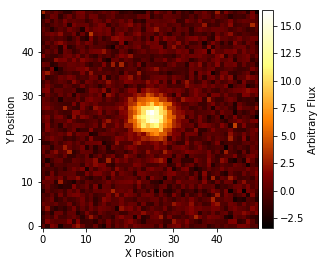

In [83]:
ax = plt.subplot(111)
im = ax.imshow(Img_data,origin='lower',cmap='afmhot',)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.ylabel('Arbitrary Flux')

# Priors [ X,Y,A]

In [86]:
def LogPrior(theta,theta_limits):
    X,Y,A = theta
    Xlimits,Ylimits = theta_limits
    
    if (X < Xlimits[0]) | (X > Xlimits[1]):
        log_X_prior = -np.inf
    else:
        log_X_prior = np.log(1.0/(Xlimits[1] - Xlimits[0]))
        
    if (Y < Ylimits[0]) | (Y > Ylimits[1]):
        log_Y_prior = -np.inf
    else:
        log_Y_prior = np.log(1.0/(Ylimits[1] - Ylimits[0]))
    
    if (A<0):
        log_A_prior = -np.inf
    else:
        log_A_prior = np.log(np.exp(-A))
    
    return log_X_prior + log_Y_prior + log_A_prior

# Likelihood

In [87]:
def LogL(theta,data,sigmay):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values are

    Returns: scalar log likelihood
    '''
    y_data = data
    model = Template_Equation(x,y,theta)
    logL = (np.sum(np.log(1./(np.sqrt((2.*np.pi)*sigmay**2)))) +
            np.sum(-0.5 * (y_data - model)**2 / sigmay**2))
    return logL

# Posterior

In [88]:
def LogPosterior(theta,theta_limits,data,sigmay):
    logP = LogL(theta,data,sigmay) + LogPrior(theta,theta_limits)
    return logP

# Metropolis Hasting

In [89]:
def metropolis(log_posterior,theta,data,sigmay,stepsize, nsteps):
    
    '''
    log_posterior: function of theta
    data:          data set
    stepsize:      scalar or vector proposal distribution width
    nsteps:        number of samples
    
    '''
    
    log_prob = log_posterior(theta,theta_limits,data,sigmay)
    
    # Store Markov chain as an array of samples:
    chain = np.empty((nsteps, len(theta)))
    log_probs = np.empty(nsteps)
    
    # Count accepted proposals:
    naccept = 0
    
    for i in range(nsteps): 
        theta_new = theta + stepsize * np.random.randn(len(theta)) #Generate new sample
        log_prob_new = log_posterior(theta_new,theta_limits,data, sigmay) # calculate post prob of new sample
        
        if (log_prob_new-log_prob) > np.log(np.random.rand()): # Accept new
            
            theta = theta_new        #
            log_prob = log_prob_new
            naccept += 1
            
        else: # Reject proposed sample
            theta = theta
            
        chain[i] = theta
        log_probs[i] = log_prob
        
    acceptance_rate = naccept/float(nsteps)
    
    return chain,log_probs,acceptance_rate

In [114]:
#Intial mcmc params
nsteps = 10000
Xstep , Ystep , Astep = 0.1,0.2,0.1
stepsize = np.array([Xstep,Ystep,Astep])

#parameter limits
Xlimits = [0.0, npix]
Ylimits = [0.0,npix]

theta_limits = (Xlimits, Ylimits)
#mcmc initial samples
X_start = 13
Y_start = 15
A_start = 10
theta = np.array([X_start,Y_start,A_start])

data = Img_data
sigmay = Noise

# Run M-H

In [115]:
Chain,Log_probs,Acceptance = metropolis(LogPosterior,theta,data,sigmay,stepsize,nsteps)


In [116]:
print(Acceptance)

0.0439


Text(0,0.5,'A')

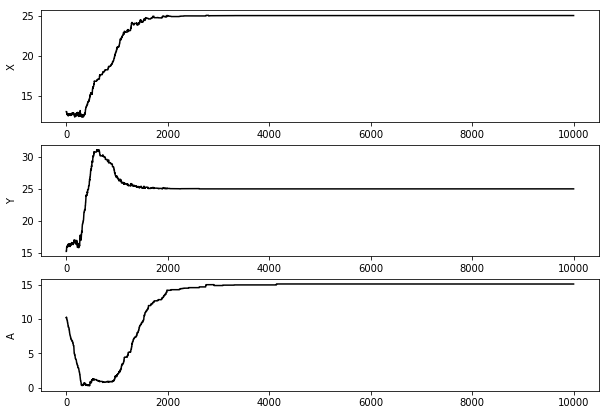

In [117]:
# Pull m and b arrays out of the Markov chain and plot them:
XX = [X for X,Y,A in Chain]
YY = [Y for X,Y,A in Chain]
AA = [A for X,Y,A in Chain]

# Traces, for convergence inspection:
plt.figure(figsize=(10,7))
plt.subplot(3,1,1)
plt.plot(XX, 'k-')
plt.ylabel('X')

plt.subplot(3,1,2)
plt.plot(YY, 'k-')
plt.ylabel('Y')

plt.subplot(3,1,3)
plt.plot(AA, 'k-')
plt.ylabel('A')

In [118]:
Mean_X = np.mean(XX[2000:])
Mean_Y = np.mean(YY[2000:])
Mean_A = np.mean(AA[2000:])

Text(0,0.5,'Arbitrary Flux')

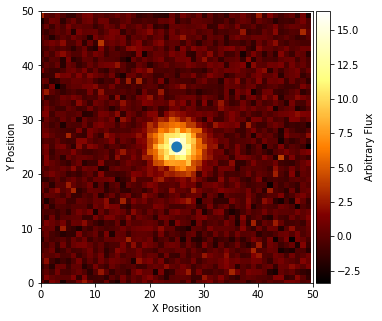

In [119]:
plt.figure(figsize=(7,5))
ax = plt.gca()
ellipses = []
plt.xlim([0,npix])
plt.ylim([0,npix])
X_pos = [Mean_X]
Y_pos = [Mean_Y]
for ra, dec in zip(X_pos,Y_pos):
    ellipse = Ellipse(xy=(ra, dec), width=2, height=2, angle=0)
    ellipses.append(ellipse)

p = PatchCollection(ellipses)
ax.add_collection(p)

im = ax.imshow(Img_data,origin='lower',cmap='afmhot',)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.ylabel('Arbitrary Flux')

# Evaluate Z

In [123]:
for i in range(0, nsteps):
    logX = -(np.arange(0, i+1) + 1.)/nsteps
    
logwt = logX.copy() + Log_probs
wt = np.exp(logwt - logwt.max())

def logsumexp(values):
    biggest = np.max(values)
    x = values - biggest
    result = np.log(np.sum(np.exp(x))) + biggest
    return result

# Prior weights
logw = logX.copy()
# Normalise them
logw -= logsumexp(logw)

# Calculate marginal likelihood
logZ = logsumexp(logw + Log_probs)
print('logZ :',logZ)

logZ : -1953.9569498578924


In [124]:
logX

array([-1.000e-04, -2.000e-04, -3.000e-04, ..., -9.998e-01, -9.999e-01,
       -1.000e+00])